In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [50]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MGIC    1259 non-null   float64
 1   NSIT    1259 non-null   float64
 2   ON      1259 non-null   float64
 3   TTD     1259 non-null   float64
 4   IDXX    1259 non-null   float64
 5   BDSI    1259 non-null   float64
 6   CDMO    1259 non-null   float64
 7   ICLR    1259 non-null   float64
 8   MEDP    1259 non-null   float64
 9   OPRX    1259 non-null   float64
 10  RGEN    1259 non-null   float64
 11  TNDM    1259 non-null   float64
 12  XOMA    1259 non-null   float64
 13  CBRE    1259 non-null   float64
 14  SBAC    1259 non-null   float64
 15  ODFL    1259 non-null   float64
 16  GLDD    1259 non-null   float64
 17  HSON    1259 non-null   float64
 18  KRNT    1259 non-null   float64
 19  QRHC    1259 non-null   float64
 20  RCII    1259 non-null   float64
 21  SAIA    1259 non-nu

## Function that saves dataframe to CSV

In [51]:
# def save_dataframe_to_csv(kind, df, ticker):
#     df.to_csv(kind + ticker + '.csv')

In [52]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [53]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [54]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [55]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [56]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [57]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [58]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [59]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [158]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU"]

#add in the weightage of stocks
port_shares = [0.070635,0.058251,0.007926,0.163185,0.048494,0.008194,0.018976,0.017402,0.006024,0.043926,0.047034,
              0.000492,0.009460,0.064368,0.135632,0.078126,0.000670,0.007985,0.008257,0.006478,0.003217,0.000217,
              0.003121,0.041926,0.002017,0.046972,0.011787,0.031827,0.006205,0.012434,0.038754]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-09,0.417696,2.328875,0.105733,0.464098,5.771756,0.015159,0.030059,1.398599,0.215177,0.104105,...,0.452801,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,39.512496,-0.001436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.041280,4.342612,0.253553,15.205089,24.108308,0.035234,0.216137,3.350059,0.838179,1.387183,...,1.384816,0.215597,31.084661,2.431371,0.488358,0.985664,1.325340,13.618931,169.405670,0.007074
2020-12-28,1.033102,4.404358,0.253236,13.587110,23.989982,0.034087,0.215188,3.330395,0.832577,1.414856,...,1.423807,0.216585,31.174847,2.438539,0.489940,1.027300,1.328697,13.616605,167.438339,-0.011613
2020-12-29,1.061724,4.346690,0.250937,13.385902,23.959431,0.033513,0.211013,3.367287,0.830529,1.364781,...,1.430934,0.217735,31.282882,2.303052,0.472533,1.053547,1.311165,13.688688,167.118280,-0.001912


## Get old data for portfolio

In [159]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-09,0.417696,2.328875,0.105733,0.464098,5.771756,0.015159,0.030059,1.398599,0.215177,0.104105,...,0.452801,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,39.512496,-0.001436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.041280,4.342612,0.253553,15.205089,24.108308,0.035234,0.216137,3.350059,0.838179,1.387183,...,1.384816,0.215597,31.084661,2.431371,0.488358,0.985664,1.325340,13.618931,169.405670,0.007074
2020-12-28,1.033102,4.404358,0.253236,13.587110,23.989982,0.034087,0.215188,3.330395,0.832577,1.414856,...,1.423807,0.216585,31.174847,2.438539,0.489940,1.027300,1.328697,13.616605,167.438339,-0.011613
2020-12-29,1.061724,4.346690,0.250937,13.385902,23.959431,0.033513,0.211013,3.367287,0.830529,1.364781,...,1.430934,0.217735,31.282882,2.303052,0.472533,1.053547,1.311165,13.688688,167.118280,-0.001912


## Forecasting

In [160]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [161]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [162]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-07,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,1.041280,4.342612,0.253553,15.205089,24.108308,0.035234,0.216137,3.350059,0.838179,1.387183,...,1.384816,0.215597,31.084661,2.431371,0.488358,0.985664,1.325340,13.618931,169.405670,0.007074
2020-12-28,1.033102,4.404358,0.253236,13.587110,23.989982,0.034087,0.215188,3.330395,0.832577,1.414856,...,1.423807,0.216585,31.174847,2.438539,0.489940,1.027300,1.328697,13.616605,167.438339,-0.011613
2020-12-29,1.061724,4.346690,0.250937,13.385902,23.959431,0.033513,0.211013,3.367287,0.830529,1.364781,...,1.430934,0.217735,31.282882,2.303052,0.472533,1.053547,1.311165,13.688688,167.118280,-0.001912


In [163]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [164]:
tot_port_df

,Total
Date,
2017-01-03,39.534262
2017-01-04,39.897552
2017-01-05,39.591896
2017-01-06,39.569306
2017-01-07,39.569306
...,...
2020-12-27,169.405670
2020-12-28,167.438339
2020-12-29,167.118280


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1459


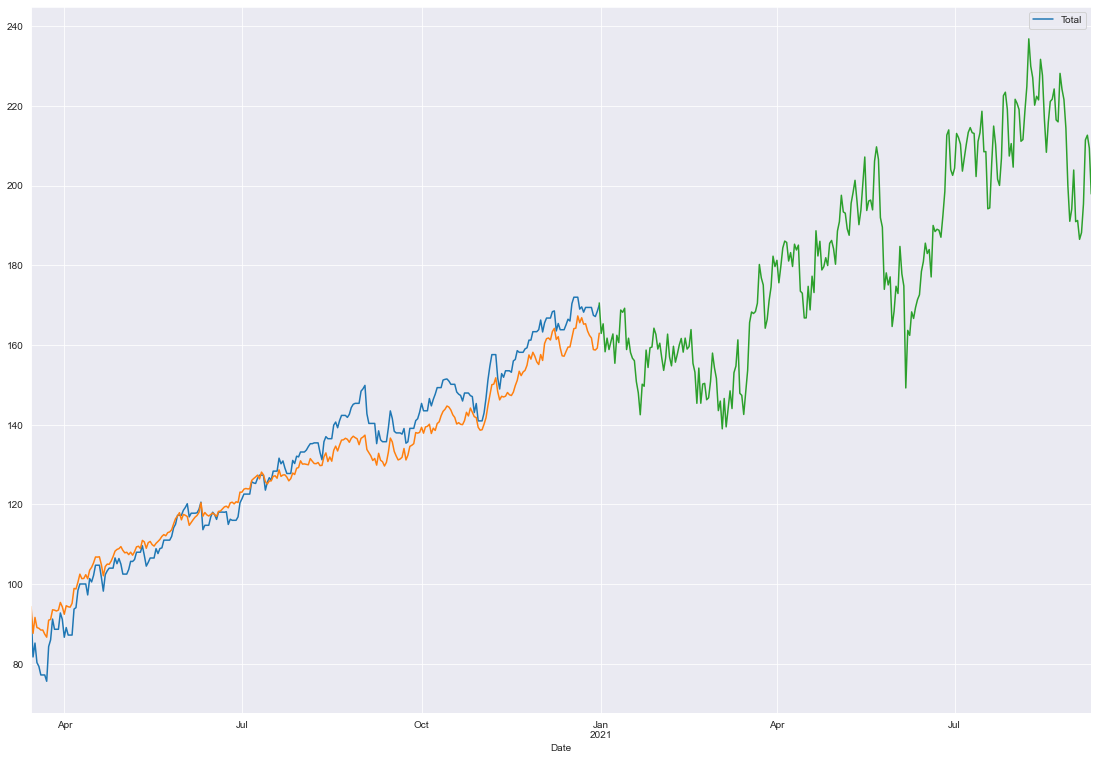

In [166]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [167]:
forecast

2020-12-31    170.531999
2021-01-01    162.883878
2021-01-02    165.296106
2021-01-03    158.281736
2021-01-04    161.705387
                 ...    
2021-09-05    195.361944
2021-09-06    211.443617
2021-09-07    212.621078
2021-09-08    209.400065
2021-09-09    197.878171
Freq: D, Length: 253, dtype: float64

In [168]:
forecast_df = pd.DataFrame(forecast)

In [169]:
forecast_df

,0
2020-12-31,170.531999
2021-01-01,162.883878
2021-01-02,165.296106
2021-01-03,158.281736
2021-01-04,161.705387
...,...
2021-09-05,195.361944
2021-09-06,211.443617
2021-09-07,212.621078
2021-09-08,209.400065


In [170]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [171]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.044849
2021-01-02,-0.030703
2021-01-03,-0.071836
2021-01-04,-0.051759
...,...
2021-09-05,0.145603
2021-09-06,0.239906
2021-09-07,0.246810
2021-09-08,0.227922


In [172]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  16.035801


## Backtesting

In [3]:
tickers2 = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [4]:
panel_data2 = panel_data2['Adj Close']

In [5]:
panel_data2

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,IDXX,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,184.110870,193.298798,13.06,10.750000,6.49,90.000000,37.959911,182.320007,92.290001,358.480011,...,496.959991,4.27,11.640000,5.25,193.660004,137.860001,31.200001,189.139999,44.540001,271.858215
2020-12-31,185.455048,194.856201,13.17,10.500000,6.52,89.129997,37.870899,180.800003,91.709999,358.350006,...,499.869995,4.20,11.540000,5.17,194.979996,139.199997,31.160000,191.630005,44.130001,279.353760
2021-01-04,177.036865,190.373672,12.96,10.420000,6.30,81.769997,37.722538,179.929993,92.300003,348.059998,...,491.769989,4.29,11.860000,5.12,192.020004,134.419998,33.360001,190.660004,39.820000,272.917694
2021-01-05,178.910843,191.431915,13.29,10.540000,6.55,85.199997,39.265465,180.860001,92.769997,345.700012,...,497.260010,4.44,12.920000,5.25,195.690002,133.990005,34.590000,194.669998,40.070000,269.897675
2021-01-06,179.322922,192.979340,14.36,10.360000,6.33,84.480003,43.004093,187.009995,90.330002,329.660004,...,483.600006,4.50,13.280000,5.64,205.479996,139.880005,35.410000,197.009995,40.119999,262.035858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,208.259995,348.309998,15.84,27.400000,6.45,143.660004,48.139999,323.529999,146.139999,663.080017,...,645.020020,3.22,29.540001,5.65,307.929993,223.369995,60.490002,264.649994,23.320000,373.462097
2021-12-27,210.330002,355.600006,15.75,27.850000,6.41,153.360001,49.200001,333.049988,154.360001,697.000000,...,654.840027,3.15,30.270000,5.40,307.619995,227.899994,63.349998,267.859985,22.049999,382.522247
2021-12-28,212.160004,356.640015,15.64,28.180000,6.60,152.449997,48.930000,330.190002,153.149994,682.200012,...,651.280029,3.11,29.280001,5.50,306.049988,218.300003,60.730000,253.770004,21.940001,383.889252


## Portfolio Analysis

In [6]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,IDXX,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.007301,0.008057,0.008423,-0.023256,0.004623,-0.009667,-0.002345,-0.008337,-0.006285,-0.000363,...,0.005856,-0.016393,-0.008591,-0.015238,0.006816,0.009720,-0.001282,0.013165,-0.009205,0.027572
2021-01-04,-0.045392,-0.023004,-0.015945,-0.007619,-0.033742,-0.082576,-0.003918,-0.004812,0.006433,-0.028715,...,-0.016204,0.021429,0.027730,-0.009671,-0.015181,-0.034339,0.070603,-0.005062,-0.097666,-0.023039
2021-01-05,0.010585,0.005559,0.025463,0.011516,0.039683,0.041947,0.040902,0.005169,0.005092,-0.006780,...,0.011164,0.034965,0.089376,0.025391,0.019113,-0.003199,0.036870,0.021032,0.006278,-0.011066
2021-01-06,0.002303,0.008083,0.080512,-0.017078,-0.033588,-0.008451,0.095214,0.034004,-0.026302,-0.046399,...,-0.027471,0.013514,0.027864,0.074286,0.050028,0.043958,0.023706,0.012020,0.001248,-0.029129
2021-01-07,-0.008317,0.044801,0.018802,0.021236,-0.028436,0.034564,-0.000690,0.036790,0.053471,0.026755,...,0.023966,0.082222,-0.003012,0.003546,0.019321,0.000143,0.059023,0.035937,0.024427,0.002305


In [7]:
portfolio_weights = [0.0131472,0.0956672,0.0070288,0.0141824,0.0021888,0.0143296,0.0129904,0.0004672,
               0.0127696,0.0160512,0.0500096,0.03064,0.0250672,0.001824,0.02364,0.0486736,0.0130144,
               0.0343008,0.0058128,0.012288,0.0064912,0.0394192,0.0375584,0.0064432,0.02008,0.0013888,
               0.0128944,0.0041264,0.034536,0.0360544,0.0069216,0.16]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,IDXX,BDSI,CDMO,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000096,0.000771,0.000059,-0.000330,0.000010,-0.000139,-0.000030,-0.000004,-0.000080,-0.000006,...,0.000220,-0.000106,-0.000173,-0.000021,0.000088,4.010852e-05,-0.000044,0.000475,-0.000064,0.004411
2021-01-04,-0.000597,-0.002201,-0.000112,-0.000108,-0.000074,-0.001183,-0.000051,-0.000002,0.000082,-0.000461,...,-0.000609,0.000138,0.000557,-0.000013,-0.000196,-1.416967e-04,0.002438,-0.000183,-0.000676,-0.003686
2021-01-05,0.000139,0.000532,0.000179,0.000163,0.000087,0.000601,0.000531,0.000002,0.000065,-0.000109,...,0.000419,0.000225,0.001795,0.000035,0.000246,-1.319983e-05,0.001273,0.000758,0.000043,-0.001771
2021-01-06,0.000030,0.000773,0.000566,-0.000242,-0.000074,-0.000121,0.001237,0.000016,-0.000336,-0.000745,...,-0.001032,0.000087,0.000560,0.000103,0.000645,1.813903e-04,0.000819,0.000433,0.000009,-0.004661
2021-01-07,-0.000109,0.004286,0.000132,0.000301,-0.000062,0.000495,-0.000009,0.000017,0.000683,0.000429,...,0.000900,0.000530,-0.000060,0.000005,0.000249,5.896673e-07,0.002038,0.001296,0.000169,0.000369


In [8]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31    0.004674
2021-01-04   -0.009881
2021-01-05    0.010291
2021-01-06   -0.001763
2021-01-07    0.021573
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,44.4%
Cumulative returns,44.4%
Annual volatility,17.1%
Sharpe ratio,2.24
Calmar ratio,4.98
Stability,0.94
Max drawdown,-8.9%


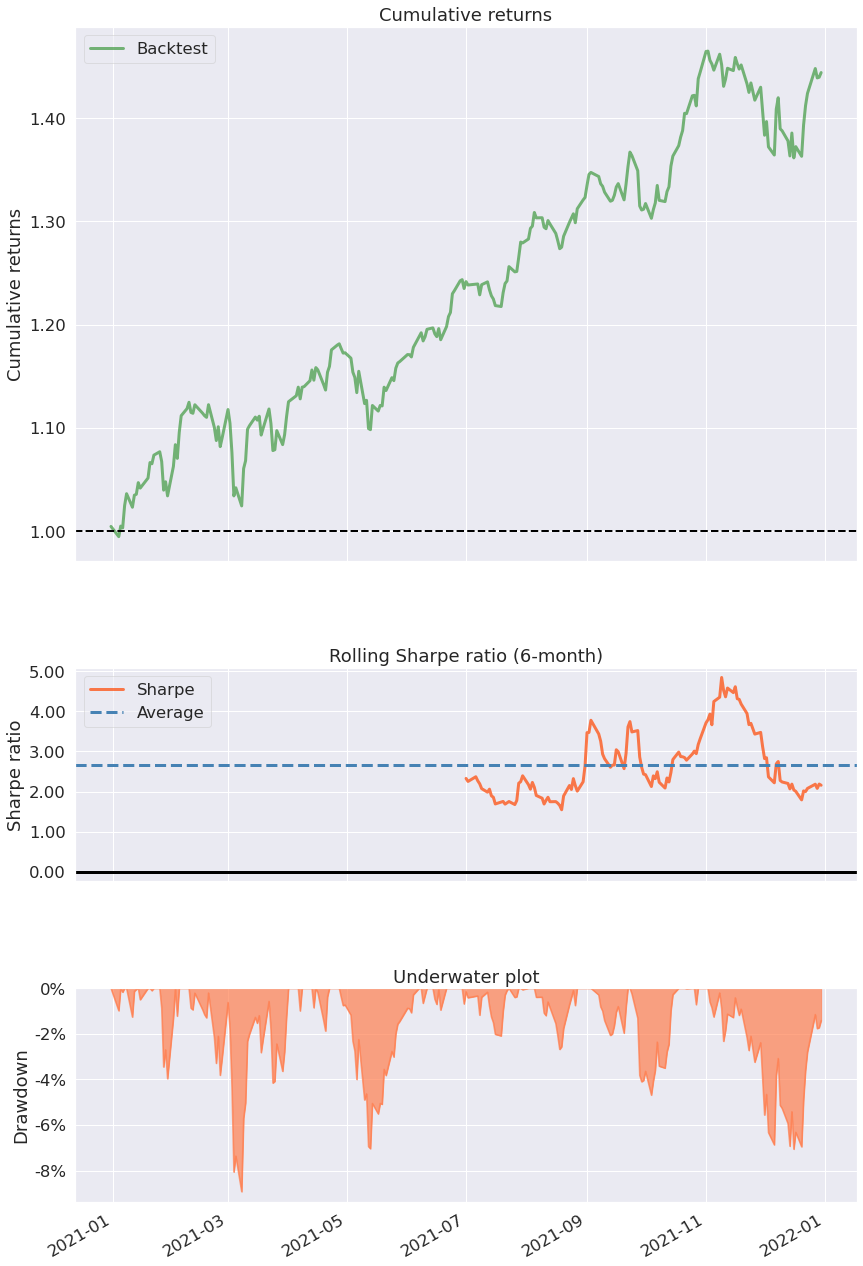

In [9]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [185]:
import itertools

In [186]:
weights = [0.0131472,0.0956672,0.0070288,0.0141824,0.0021888,0.0143296,0.0129904,0.0004672,
               0.0127696,0.0160512,0.0500096,0.03064,0.0250672,0.001824,0.02364,0.0486736,0.0130144,
               0.0343008,0.0058128,0.012288,0.0064912,0.0394192,0.0375584,0.0064432,0.02008,0.0013888,
               0.0128944,0.0041264,0.034536,0.0360544,0.0069216,0.16]

In [187]:
panel_data2 = panel_data2 * weights

In [188]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [189]:
#forecasted portfolio value
panel_data2

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,1.071946,4.394456,0.257436,13.348533,24.099578,0.034988,0.220881,3.370071,0.830469,1.370491,...,0.021797,1.409133,0.222233,32.635208,2.331724,0.480445,1.071852,1.333546,13.594128,168.434288
2020-12-31,1.066494,4.432318,0.259418,13.071118,24.240696,0.034415,0.218983,3.393042,0.838541,1.368734,...,0.022406,1.453994,0.224411,33.146730,2.288951,0.487408,1.085751,1.314398,13.487555,170.032628
2021-01-04,1.019473,4.385135,0.258942,12.621218,23.847894,0.035152,0.225055,3.341532,0.809746,1.465371,...,0.022482,1.432611,0.216747,34.278757,2.213745,0.479496,1.036793,1.285800,13.811925,168.806281
2021-01-05,1.015384,4.477172,0.263302,12.867789,24.114127,0.036381,0.245170,3.405397,0.807156,1.519400,...,0.023776,1.463217,0.217735,34.529586,2.308340,0.490257,1.070300,1.344861,14.203341,170.315553
2021-01-06,0.997666,4.659497,0.269960,12.085644,23.451699,0.036873,0.252001,3.575763,0.842637,1.555420,...,0.023598,1.462798,0.223423,35.509892,2.415038,0.523806,1.131668,1.410637,14.077390,169.664399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1.459780,6.012668,0.529140,15.673920,31.279601,0.026385,0.560551,5.358598,1.345581,2.657084,...,0.061329,3.894925,0.312050,50.119124,2.786093,0.847901,1.201040,2.035321,15.174516,240.412779
2021-12-27,1.494686,6.058104,0.553076,15.939911,31.755812,0.025811,0.574404,5.353203,1.372870,2.782712,...,0.061708,4.024896,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,245.394348
2021-12-28,1.470950,6.074414,0.541504,15.468306,31.583174,0.025483,0.555617,5.325882,1.315039,2.667626,...,0.061212,3.899537,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,243.697569


In [190]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [191]:
actual_portfolio_value

[168.4342882487135,
 170.03262827585795,
 168.80628064714196,
 170.31555274910497,
 169.66439851267864,
 175.16166199654862,
 180.56269877632093,
 175.1780828963785,
 177.2109941182275,
 177.09030672178793,
 176.7891042642293,
 176.6895835844145,
 177.81389559532118,
 180.34210027045253,
 179.7979567204447,
 179.7278881739807,
 181.0902453603229,
 179.0617342928352,
 174.04168076236388,
 174.84063903122282,
 171.19730185228246,
 177.32604122030446,
 182.49903738690332,
 178.56058130903003,
 180.80458319788596,
 182.11310020474335,
 181.9782203154087,
 182.26166677963207,
 180.2419799676247,
 181.55911933459186,
 182.98226495559925,
 180.7494126748176,
 180.05674541272117,
 180.61798940292982,
 181.42491767349006,
 175.73525017621566,
 171.97301652789022,
 175.21824094361497,
 170.34762864742896,
 171.0196288623395,
 175.29120324222993,
 172.109717420682,
 164.77873936406993,
 158.43396227426527,
 160.26593019165372,
 157.7634375873494,
 166.5677396402645,
 167.39581783679438,
 172.5298

In [192]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [193]:
forecasted_portfolio_value

[170.53199876247538,
 162.88387848626817,
 165.29610639182647,
 158.2817362492607,
 161.70538657879027,
 158.83282614681465,
 160.87355506979728,
 162.75646617090712,
 155.39464920809385,
 162.41384735143544,
 160.58201314794968,
 168.7556723388083,
 168.1801092907284,
 169.2061839362149,
 158.8377368792444,
 161.68833696387816,
 158.11873338600182,
 156.66318550421917,
 156.03836549785086,
 150.8035040741111,
 147.97871814593483,
 142.48202145441473,
 150.14399146579387,
 149.62830078883667,
 158.70678995873052,
 154.33571931032577,
 159.281477772692,
 159.47234354480545,
 164.20096563046906,
 162.66225244368232,
 158.965520809073,
 160.4356671834571,
 156.8002797897618,
 153.61362437001281,
 156.73004193612815,
 162.71187511039383,
 156.97964505883442,
 154.75198764166845,
 159.66442757685982,
 155.66492953193085,
 157.70150615652346,
 160.0151433649596,
 161.6247155774075,
 158.1890465067723,
 161.71369928192192,
 158.95564336257866,
 159.5815732999183,
 163.85131812555062,
 155.384

## Calculate MAPE of forecasted period

In [194]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.09
MAPE % : 8.89 %



## Mean Squared Error

In [195]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

476.4983431578214


## Forecast for future

In [196]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU"]

#add in the weightage of stocks
port_shares = [0.070635,0.058251,0.007926,0.163185,0.048494,0.008194,0.018976,0.017402,0.006024,0.043926,0.047034,
              0.000492,0.009460,0.064368,0.135632,0.078126,0.000670,0.007985,0.008257,0.006478,0.003217,0.000217,
              0.003121,0.041926,0.002017,0.046972,0.011787,0.031827,0.006205,0.012434,0.038754]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-09,0.417696,2.328875,0.105733,0.464098,5.771756,0.015159,0.030059,1.398599,0.215177,0.104105,...,0.452801,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,39.512496,-0.001436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.494686,6.058104,0.553076,15.939911,31.755812,0.025811,0.574404,5.353203,1.372870,2.782712,...,4.024896,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,245.394348,0.020721
2021-12-28,1.470950,6.074414,0.541504,15.468306,31.583174,0.025483,0.555617,5.325882,1.315039,2.667626,...,3.899537,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,243.697569,-0.006914
2021-12-29,1.473742,6.178101,0.546339,15.106035,31.797031,0.025401,0.575163,5.359642,1.328111,2.613158,...,3.916727,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,244.319351,0.002551


In [197]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-09,0.417696,2.328875,0.105733,0.464098,5.771756,0.015159,0.030059,1.398599,0.215177,0.104105,...,0.452801,0.112023,2.172737,0.555069,0.186472,0.240878,0.341935,2.642635,39.512496,-0.001436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.494686,6.058104,0.553076,15.939911,31.755812,0.025811,0.574404,5.353203,1.372870,2.782712,...,4.024896,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,245.394348,0.020721
2021-12-28,1.470950,6.074414,0.541504,15.468306,31.583174,0.025483,0.555617,5.325882,1.315039,2.667626,...,3.899537,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,243.697569,-0.006914
2021-12-29,1.473742,6.178101,0.546339,15.106035,31.797031,0.025401,0.575163,5.359642,1.328111,2.613158,...,3.916727,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,244.319351,0.002551


In [198]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [199]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [200]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.414692,2.369651,0.100581,0.439457,5.702894,0.014339,0.030059,1.300103,0.216322,0.106740,...,0.444416,0.110537,2.038491,0.570413,0.175594,0.251178,0.333853,2.590705,39.534262,NaN
2017-01-04,0.417696,2.411591,0.103038,0.442231,5.622879,0.014339,0.031061,1.336822,0.219213,0.105422,...,0.454897,0.114069,2.132435,0.571372,0.180256,0.252481,0.346909,2.689915,39.897552,0.009189
2017-01-05,0.420702,2.368486,0.101849,0.447943,5.623364,0.015159,0.030059,1.326206,0.215840,0.106740,...,0.448608,0.112731,2.130180,0.570989,0.178702,0.254095,0.347530,2.663563,39.591896,-0.007661
2017-01-06,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
2017-01-07,0.417696,2.335283,0.103117,0.452022,5.739750,0.015569,0.030059,1.368667,0.215780,0.106740,...,0.450704,0.113026,2.151411,0.562933,0.184918,0.246463,0.343800,2.645735,39.569306,-0.000571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.494686,6.058104,0.553076,15.939911,31.755812,0.025811,0.574404,5.353203,1.372870,2.782712,...,4.024896,0.313220,51.384547,2.795759,0.863480,1.222137,2.057703,15.530665,245.394348,0.020721
2021-12-28,1.470950,6.074414,0.541504,15.468306,31.583174,0.025483,0.555617,5.325882,1.315039,2.667626,...,3.899537,0.312675,51.127611,2.814971,0.865069,1.219096,2.043528,15.504313,243.697569,-0.006914
2021-12-29,1.473742,6.178101,0.546339,15.106035,31.797031,0.025401,0.575163,5.359642,1.328111,2.613158,...,3.916727,0.313381,51.020514,2.823458,0.863798,1.279347,2.053599,15.540354,244.319351,0.002551


In [201]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [202]:
tot_port_df

,Total
Date,
2017-01-03,39.534262
2017-01-04,39.897552
2017-01-05,39.591896
2017-01-06,39.569306
2017-01-07,39.569306
...,...
2021-12-27,245.394348
2021-12-28,243.697569
2021-12-29,244.319351


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


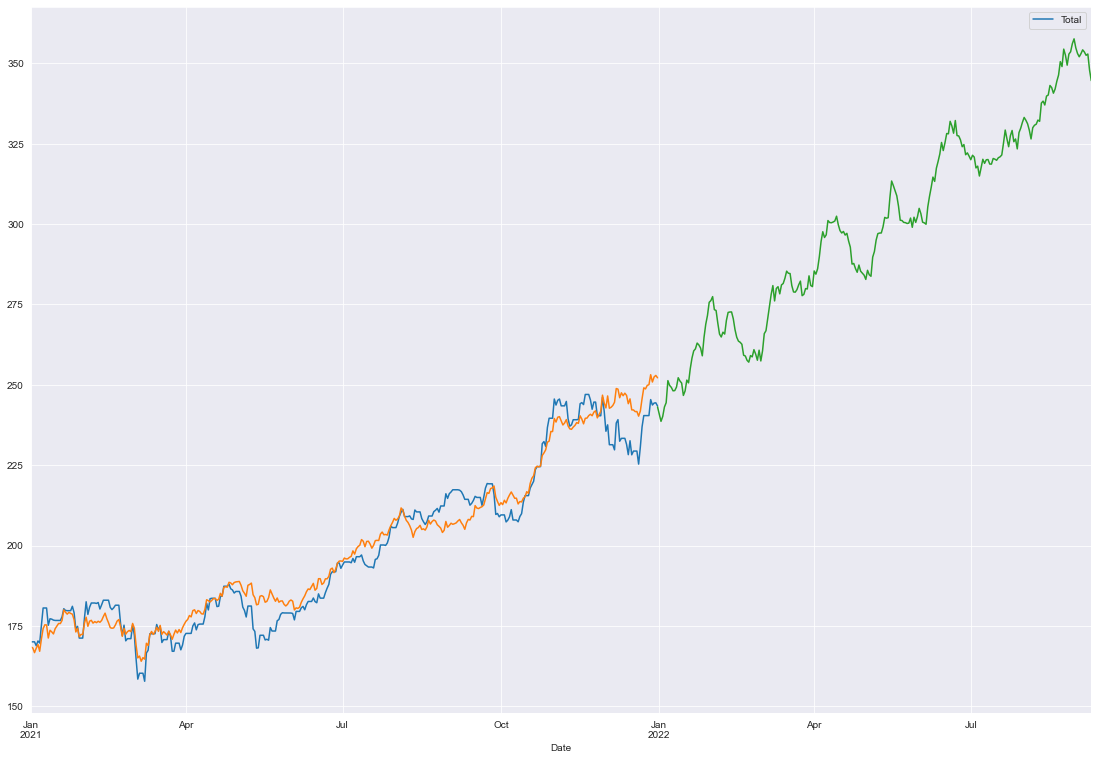

In [203]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [204]:
## Calculate annualized returns for forecasted

In [205]:
forecast

2021-12-31    243.101373
2022-01-01    240.824711
2022-01-02    238.626986
2022-01-03    240.144328
2022-01-04    243.098429
                 ...    
2022-09-05    353.519671
2022-09-06    352.494686
2022-09-07    352.901521
2022-09-08    347.913188
2022-09-09    344.610348
Freq: D, Length: 253, dtype: float64

In [206]:
forecast_df = pd.DataFrame(forecast)

In [207]:
forecast_df

,0
2021-12-31,243.101373
2022-01-01,240.824711
2022-01-02,238.626986
2022-01-03,240.144328
2022-01-04,243.098429
...,...
2022-09-05,353.519671
2022-09-06,352.494686
2022-09-07,352.901521
2022-09-08,347.913188


In [208]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [209]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.009365
2022-01-02,-0.018405
2022-01-03,-0.012164
2022-01-04,-0.000012
...,...
2022-09-05,0.454207
2022-09-06,0.449991
2022-09-07,0.451664
2022-09-08,0.431144


In [210]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  41.755822
